# Reproducibility with original data (seqFISH)

This tutorial demonstrates how to pseudo-spatiotemporal analysis on seqFISH mouse embryo data using SODB and SpaceFlow.

A reference paper can be found at https://www.nature.com/articles/s41467-022-31739-w.

This tutorial refers to the following tutorial at https://github.com/hongleir/SpaceFlow/blob/master/tutorials/seqfish_mouse_embryogenesis.ipynb. At the same time, the way of loadding data is modified by using SODB.

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several python packages commonly used in data analysis and visualization.
# numpy (imported as np) is a package for numerical computing with arrays.
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis.
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization.
import matplotlib.pyplot as plt

In [3]:
# from SpaceFlow package import SpaceFlow module
from SpaceFlow import SpaceFlow

In [4]:
# Imports a palettable package
import palettable
# Create three variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_pspace = palettable.cartocolors.diverging.TealRose_7.mpl_colormap
cmp_domain = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct = palettable.cartocolors.qualitative.Safe_10.mpl_colors

## Streamline development of loading spatial data with SOBD

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialize the sodb object
sodb = pysodb.SODB()

In [7]:
# Define names of the dataset_name and experiment_name
dataset_name = 'lohoff2021integration'
experiment_name = 'lohoff2020highly_seqFISH_mouse_Gastrulation'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
#%%time
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[lohoff2020highly_seqFISH_mouse_Gastrulation] in dataset[lohoff2021integration]


In [8]:
# Filter out genes
sc.pp.filter_genes(adata, min_cells=3)

## Perform SpaceFlow for pseudo-spatiotemporal analysis

In [10]:
# Create SpaceFlow Object
#%%time
sf = SpaceFlow.SpaceFlow(
    count_matrix=adata.X, 
    spatial_locs=adata.obsm['spatial'], 
    sample_names=adata.obs_names, 
    gene_names=adata.var_names
)

In [11]:
# Preprocess data
#%%time
sf.preprocessing_data(n_top_genes=3000)

In [12]:
# Train a deep graph network model
#%%time
sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, 
    lr=1e-3, 
    epochs=1000, 
    max_patience=50, 
    min_stop=100, 
    random_seed=42, 
    gpu=0, 
    regularization_acceleration=True, 
    edge_subset_sz=1000000
)



Epoch 2/1000, Loss: 1.4433507919311523
Epoch 12/1000, Loss: 1.1957049369812012
Epoch 22/1000, Loss: 0.899651050567627
Epoch 32/1000, Loss: 0.5220378637313843
Epoch 42/1000, Loss: 0.25793352723121643
Epoch 52/1000, Loss: 0.1524793654680252
Epoch 62/1000, Loss: 0.11322928965091705
Epoch 72/1000, Loss: 0.0992421880364418
Epoch 82/1000, Loss: 0.08421209454536438
Epoch 92/1000, Loss: 0.08441481739282608
Epoch 102/1000, Loss: 0.07488371431827545
Epoch 112/1000, Loss: 0.07958266884088516
Epoch 122/1000, Loss: 0.07067456096410751
Epoch 132/1000, Loss: 0.07084371149539948
Epoch 142/1000, Loss: 0.06988966464996338
Epoch 152/1000, Loss: 0.06983029097318649
Epoch 162/1000, Loss: 0.07103952765464783
Epoch 172/1000, Loss: 0.06583818048238754
Epoch 182/1000, Loss: 0.0638948529958725
Epoch 192/1000, Loss: 0.06412710249423981
Epoch 202/1000, Loss: 0.06145592778921127
Epoch 212/1000, Loss: 0.06415022164583206
Epoch 222/1000, Loss: 0.0672992393374443
Epoch 232/1000, Loss: 0.06305063515901566
Epoch 242/10

array([[-0.5199552 , -0.17967458,  0.7573716 , ..., -0.1183727 ,
        -0.00703658,  2.489347  ],
       [-0.46287113, -0.19304845,  1.0321252 , ..., -0.19984664,
        -0.06295489,  2.3953645 ],
       [-0.52252036,  0.6154977 ,  0.13132505, ..., -0.03820756,
        -0.00726214,  2.0950577 ],
       ...,
       [-0.23219149,  0.9938329 , -0.00803952, ..., -0.03670396,
         0.5799729 ,  1.5172849 ],
       [-0.32494605, -0.07422221,  1.0354829 , ..., -0.13825543,
         0.98951554,  2.3516695 ],
       [-0.2175944 ,  0.82438576,  0.0362829 , ..., -0.0678086 ,
         0.89376557,  1.5167462 ]], dtype=float32)

In [13]:
# Idenfify the spatiotemporal patterns through pseudo-Spatiotemporal Map (pSM)
sf.pseudo_Spatiotemporal_Map(pSM_values_save_filepath="./pSM_values.tsv", n_neighbors=20, resolution=1.0)

Performing pseudo-Spatiotemporal Map
pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at ./pSM_values.tsv!


In [14]:
# Create a new column called 'pspace' from pSM values of cells or spots.
adata.obs['pspace'] = sf.pSM_values

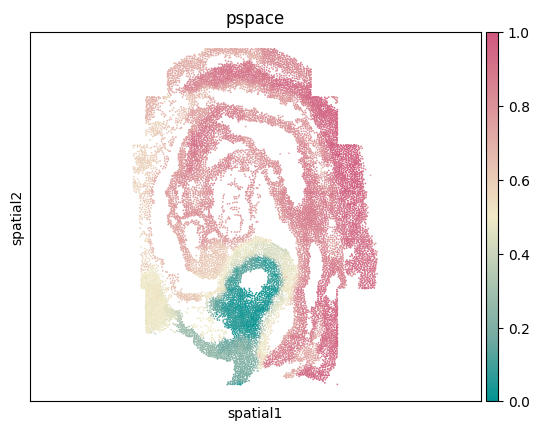

In [15]:
# Visualize spatial coordinates in a scatterplot colored by 'pspace'
ax = sc.pl.embedding(adata,basis='spatial',color='pspace',show=False,color_map=cmp_pspace)
ax.axis('equal')
plt.savefig('figures/seqFISH_pspace.png',bbox_inches='tight',transparent=True,dpi=400)
plt.savefig('figures/seqFISH_pspace.pdf',bbox_inches='tight',transparent=True,dpi=400)



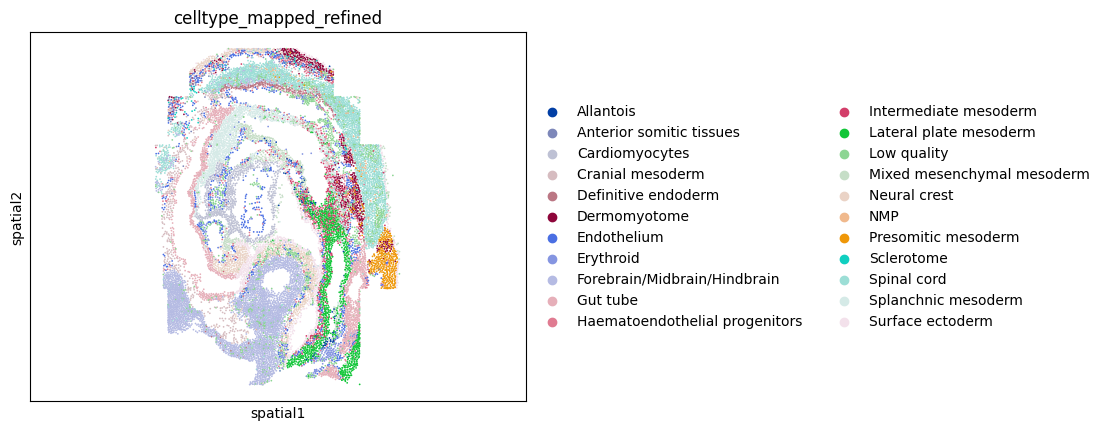

In [16]:
# Visualize spatial coordinates in a scatterplot colored by 'celltype_mapped_refined'
ax = sc.pl.embedding(adata,basis='spatial',color='celltype_mapped_refined',show=False)
ax.axis('equal')
plt.savefig('figures/seqFISH_ct.png',bbox_inches='tight',transparent=True,dpi=400)
plt.savefig('figures/seqFISH_ct.pdf',bbox_inches='tight',transparent=True,dpi=400)